In [1]:
#Importando las bibliotecas a usar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# $\underline{\text{Copiando el codigo anterior}}$

In [2]:
#Importando las bibliotecas a utilizar
import numpy as np
import pandas as pd


#==========CREANDO UN DF DEL ARCHIVO DE DATOS Y UN DF PROVICIONAL DE TRABAJO====================
# Creamos un DataFrame compra a partir del archivo de texto de los datos diarios de la estacion en nuestro repositorio:

url = "https://raw.githubusercontent.com/Refer-MF/Fisica-Computacional-2020-1-Gustavo-Medina/master/Actividad%201/Datos%20diarios.txt"
#La URL del archivo de datos que esta guardado en mi repositorio de GH
encabezados=['FECHA','PRECIP','EVAP','TMax','TMin'] #Encabezados de las columnas, de acuerdo al archivo que se leera


df_datclim = pd.read_csv(url, names=encabezados, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
#El df read se declara con (url del archivo que usaras, names=como quieres que se titulen las columnas, encoding=formato del archivo que en este caso es 
#espanol, sep= la separacion de los datos en el archivo, header= (Encabezado?), skiprows=numero de renglones que quieres que se omitan del principio, skipfooter= numero de renglones que quieres que se omitan del final, engine= el motor que lo leera)


#print(df_datclim.head(10)) #Para imprimir los primeros tres renglones del df
#print(df_datclim.tail(10)) #Para imprimir los ultimos tres renglones del df
#df_datclim.shape #Para imprimir la forma del df (Renglones, columnas). Mi df tiene una forma de (24364,5) 
#df_datclim.info() #Para imprimir la informacion del df (Cuantas columnas, nombres de columnas, conteo de datos por columnas, tipo de dato)


df_datclim0=df_datclim.copy() #Creando un df con el cual trabajaremos, el otro lo mantendremos intacto
#df_datclim0.head()

str_Nulo='Nulo'
df_datclim1=df_datclim0.replace(to_replace=str_Nulo, value=' ', regex=True) #Este df no tendra ningun "Nulo" en sus casillas.
#df_datclim1.head()

#======================PASANDO LOS DATOS A NUMERICOS======================
cols_list=['PRECIP','EVAP','TMax','TMin'] #Un diccionario que usaremos para analizar el df en un loop for
for cols in cols_list:
  df_datclim1[cols]=pd.to_numeric(df_datclim1[cols], errors='coerce') #Pasando los datos en las columnas del diccionario a numerico y los que no apliquen
#seran mostrados como un 'NaN' (Eso significa 'errors='coerce'')

#df_datclim1.info() #A partir de esta informacion, vemos que a mi set de datos no le hace falta muchos. Pero para asegurarnos, contaremos los fatos faltantes.

print('\n ') #Solo para ayudar en la lectura

#=============CONTANDO LOS DATOS FALTANTES=====================
#df_datclim1.isnull().sum() #*Sumando los valores nulos. A partir de esta informacion vemos que la precipitacion no tiene ningun dato nulo, la evaporacion
#tiene la mayoria de datos nulos con 214, la temperatura maxima y la minima les faltan a los dos 5 datos. De los 70 y algo años que lleva activa la
#estacion, me parece que le falta muy pocos datos.

#df_datclim1.head()
#df_datclim1.tail()

#============ANALISIS ESTADISTICO===============
#df_datclim1.describe() #A partir de esto podemos observar que los datos no tienen ninguna incoherencia. Los datos de temperatura, en base a mi experiencia
#y mi vivencia en esta region, parecen normales, exceptuando la temperatura minima de -2 grados, ya que en la ciudad de Obregon nunca he experimentado 
#temperaturas bajo cero (sin embargo no es algo sorpresivo, ya que en epocas de invierno las temperaturas llegan hasta 6 grados centigrados).
#La precipitacion maxima es de 137.5 mm, lo cual es bastante, y se puede explicar con algun huracan o tormenta tropical.

#==============TRABAJANDO CON FECHAS===============
df_datclim2=df_datclim1.copy()
#df_datclim2['FECHA'].head() #Para imprimir solo las de la columna 'FECHA'

df_datclim2['FECHA']=pd.to_datetime(df_datclim2['FECHA'], dayfirst=True).copy() #Cambiando los datos de la columna FECHAS a fechas con el dia primero.
#df_datclim2['FECHA'].head()
df_datclim2.dtypes #Checando el tipo de dato de las columnas.

df_datclim2['Año']=df_datclim2['FECHA'].dt.year #Añadiendo una columna 'Año' al df con el año respectivo de la medida
df_datclim2['Mes']=df_datclim2['FECHA'].dt.month #Añadiendo una columna 'Mes' al df con el mes respectivo de la medida

#df_datclim2.head()
#df_datclim2.tail()

#df_datclim2.info() #Para checar que la informacion este correcta

#===============================================================================
#============FIN DE LA PRIMERA SEMANA===========================================
#===============================================================================

df_datclim3=df_datclim2.copy() #Df con el que trabajaremos en esta semana

#Creamos una copia de trabajo
df_datclim_ts=df_datclim3.copy()
#Redefinimos el indice como "Fecha"
df_datclim_ts=df_datclim_ts.set_index('FECHA')

#print(df_datclim_ts.head())


#Ahora vamos a definir diferentes df de periodos de 30 anos, aproximadamente:
df_datclim_ts30=df_datclim_ts[(df_datclim_ts['Año'] >= 1949) & (df_datclim_ts['Año'] < 1979)]
df_datclim_ts60=df_datclim_ts[(df_datclim_ts['Año'] >= 1979) & (df_datclim_ts['Año'] < 2009)]
df_datclim_ts90=df_datclim_ts[(df_datclim_ts['Año'] >= 2009) & (df_datclim_ts['Año'] < 2016)]
df_datclim_tsNov=df_datclim_ts[(df_datclim_ts['Año'] >= 1990) & (df_datclim_ts['Año'] < 2016)]
#Ahora verificamos
#df_datclim_ts30.head()



# $\underline{\text{Actividad de esta semana:}}$

In [3]:
# Incluir en la Primera Celda: 
# from statsmodels.tsa.stattools import adfuller

# Función para probar la estacionaria de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts): 
     #Determinar la Estadística de promedios móviles
     rolmean = df_ts.rolling(window=365, center=True).mean()
     rolstd = df_ts.rolling(window=365, center=True).std()

     # Define el tamaño de la figura
     plt.rcParams["figure.figsize"] = (12,6)

     #Graficar la Estadística de promedios móviles
     plt.plot(df_ts, color='blue',label='Original')
     plt.plot(rolmean, color='red', label='Rolling Mean')
     plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
     plt.legend(loc='best')
     plt.title('Promedio Móvil y Desviación Estándar')
     plt.grid()
     plt.show()

     #Realiza la Prueba Aumentada de Dickey-Fuller:
     print('Resultados de la Prueba de Dickey-Fuller:')
     dftest = adfuller(df_ts, autolag='AIC')
     dfoutput = pd.Series(dftest[0:4],
          index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
     for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value

     print(dfoutput)

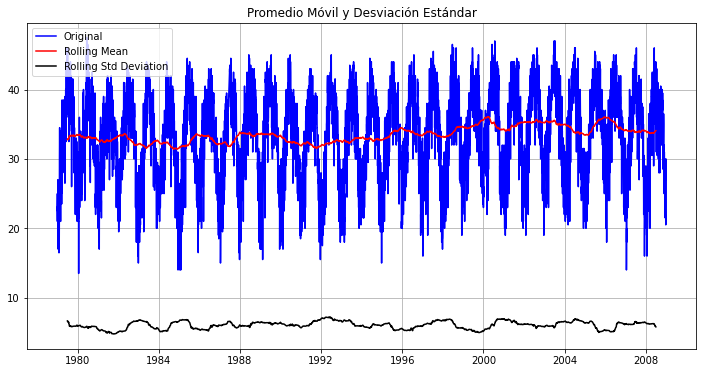

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.223198e+00
p-value                        2.085322e-10
#Lags Used                     1.900000e+01
Number of Observations Used    1.090800e+04
Critical Value (1%)           -3.430950e+00
Critical Value (5%)           -2.861805e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


In [4]:
#Ahora vamos a hacer nuestra primera serie de tiempo a analizar, tomando en cuenta que no deben de haber huecos:
start, end = '1979-01', '2009-12'

ts_60 = df_datclim_ts60.loc[start:end].copy()
#ts_60.head()
#ts_60.isnull().sum() #Podemos ver que la unica variable donde faltand atos en este periodo es en la evaporacion, con 66 datos faltantes

#Ahora vamos a hacer una serie de tiempo de la variable que queramos estudiar:
ts_TMaxTest=ts_60['TMax'].copy()
#ts_TMaxTest.head()

test_stationarity(ts_TMaxTest)


$\text{Observamos que el valor de p es menor a 0.05 } (2.085322x10^{-10})$

$\text{Sin embargo, vamos a reducir su tendencia un poco mas, ya que aun se ve muy poco lineal.} $

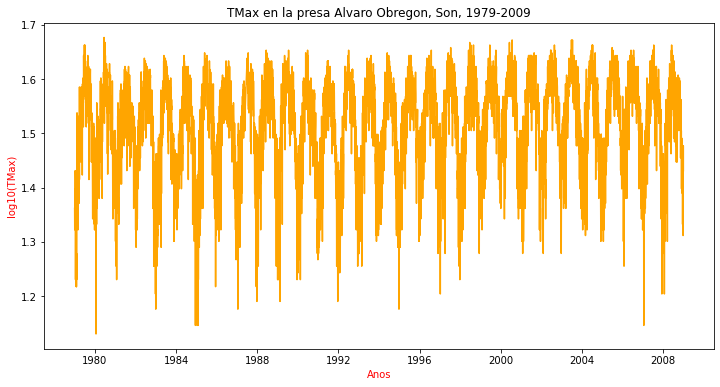

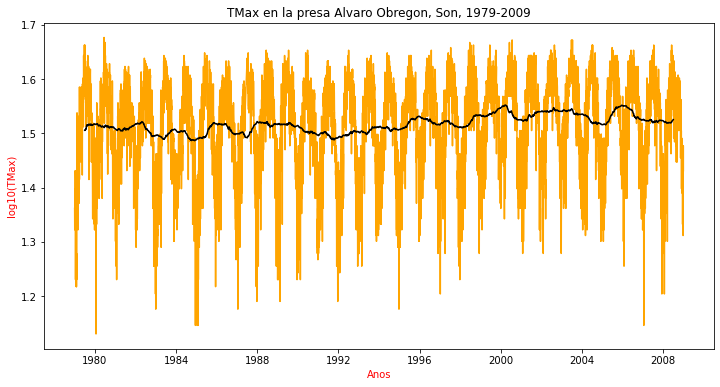

FECHA
1979-07-02    0.101780
1979-07-03    0.112273
1979-07-04    0.117295
1979-07-05    0.142175
1979-07-06    0.156396
Name: TMax, dtype: float64

In [5]:
#Vamos a reducir la escala usando una escala logaritmica de log10:

ts_TMaxTest_log10=np.log10(ts_TMaxTest)
plt.plot(ts_TMaxTest_log10, color='orange')
plt.xlabel('Anos',color='red')
plt.ylabel('log10(TMax)', color='red')
plt.title('TMax en la presa Alvaro Obregon, Son, 1979-2009')
plt.show()

#Graficaremos tambien el promedio movible de 365 dias:
MovAv365TMaxTest=ts_TMaxTest_log10.rolling(365, center=True).mean()

ts_TMaxTest_log10=np.log10(ts_TMaxTest)
plt.plot(ts_TMaxTest_log10, color='orange')
plt.xlabel('Anos',color='red')
plt.ylabel('log10(TMax)', color='red')
plt.plot(MovAv365TMaxTest, color='black')
plt.title('TMax en la presa Alvaro Obregon, Son, 1979-2009')
plt.show()

#Ahora haremos la diferencia del logaritmo y el promedio
ts_TMaxTest_log10_Av_diff=ts_TMaxTest_log10-MovAv365TMaxTest
ts_TMaxTest_log10_Av_diff.dropna(inplace=True)
ts_TMaxTest_log10_Av_diff.head()

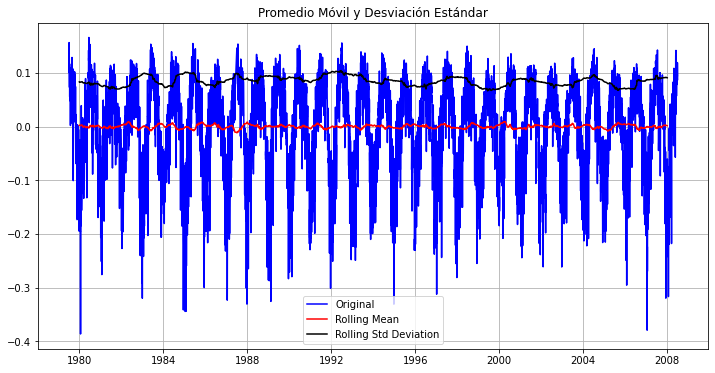

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.263309e+00
p-value                        1.659710e-10
#Lags Used                     1.900000e+01
Number of Observations Used    1.054400e+04
Critical Value (1%)           -3.430970e+00
Critical Value (5%)           -2.861814e+00
Critical Value (10%)          -2.566916e+00
dtype: float64


In [6]:
#Ahor vamos a probar la estacionaridad de la serie pero con escala logaritmica:
test_stationarity(ts_TMaxTest_log10_Av_diff)

$\text{Aunque el promedio movible y la desviacion estandar se ven mas lineales, intentaremos hacerlas aun mas lineales}$

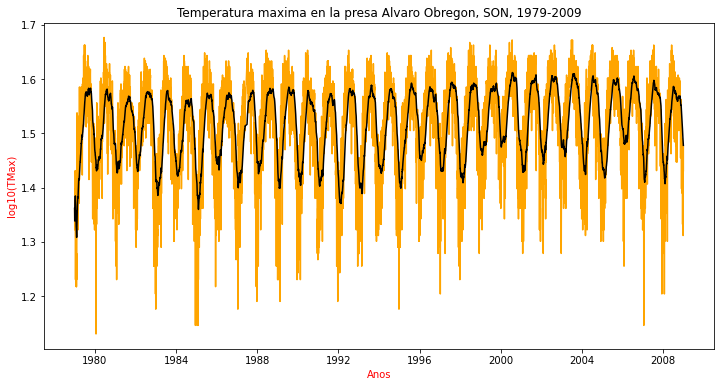

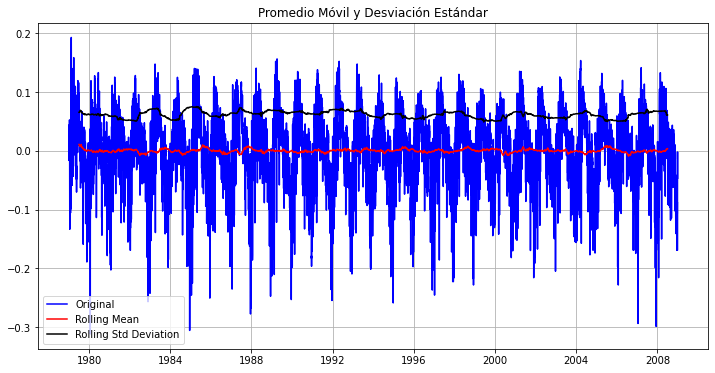

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.470057e+00
p-value                        1.486028e-13
#Lags Used                     2.800000e+01
Number of Observations Used    1.089900e+04
Critical Value (1%)           -3.430950e+00
Critical Value (5%)           -2.861805e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


In [7]:
#Utilizaremos promedios movibles a EXPONENCIALES:
ts_TMaxTest_log10EWM=ts_TMaxTest_log10.ewm(halflife=30).mean()

plt.plot(ts_TMaxTest_log10,color='orange')
plt.plot(ts_TMaxTest_log10EWM, color='black')
plt.xlabel('Anos',color='red')
plt.ylabel('log10(TMax)',color='red')
plt.title('Temperatura maxima en la presa Alvaro Obregon, SON, 1979-2009')
plt.show()

#Ahora hacemos la diferencia del promedio exponencial movible y el logaritmo de la temperatura:
ts_TMaxTest_log10_EWM_diff=ts_TMaxTest_log10-ts_TMaxTest_log10EWM

test_stationarity(ts_TMaxTest_log10_EWM_diff)

$\text{Ahora que hemos logrado una linealidad aceptable, podemos proseguir con el analisis de la serie.}$

$\text{-Jugando con el valor de 'halflife':}$

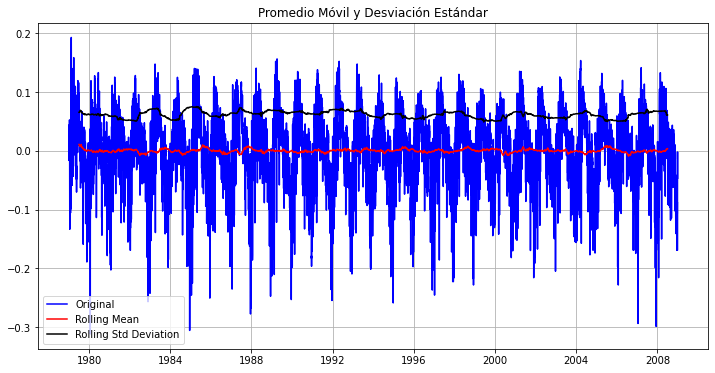

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.470057e+00
p-value                        1.486028e-13
#Lags Used                     2.800000e+01
Number of Observations Used    1.089900e+04
Critical Value (1%)           -3.430950e+00
Critical Value (5%)           -2.861805e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


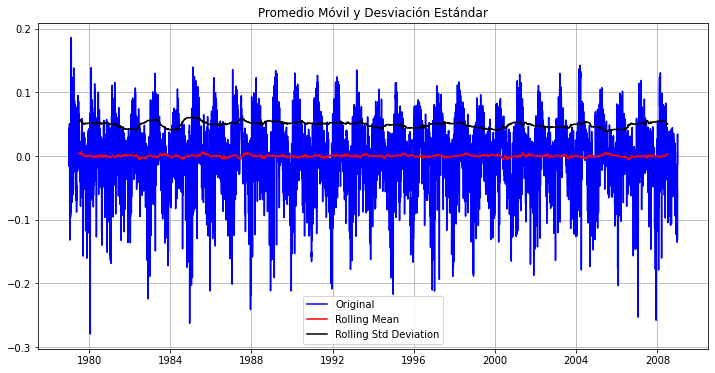

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.112646e+01
p-value                        3.364574e-20
#Lags Used                     2.800000e+01
Number of Observations Used    1.089900e+04
Critical Value (1%)           -3.430950e+00
Critical Value (5%)           -2.861805e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


In [8]:
ts_TMaxTest_log10EWM=ts_TMaxTest_log10.ewm(halflife=30).mean()
ts_TMaxTest_log10_EWM_diff=ts_TMaxTest_log10-ts_TMaxTest_log10EWM

test_stationarity(ts_TMaxTest_log10_EWM_diff)


ts_TMaxTest_log10EWM=ts_TMaxTest_log10.ewm(halflife=15).mean()
ts_TMaxTest_log10_EWM_diff=ts_TMaxTest_log10-ts_TMaxTest_log10EWM

test_stationarity(ts_TMaxTest_log10_EWM_diff)

$\text{Lo que se intentara hacer ahora es eliminar la estacionaridad de los datos.}$

$\text{Esto se puede hacer haciendo la descomposicion que hicimos en la actividad pasada o aplicando la funcion .shift() de pandas y haciendo una diferencia.}$

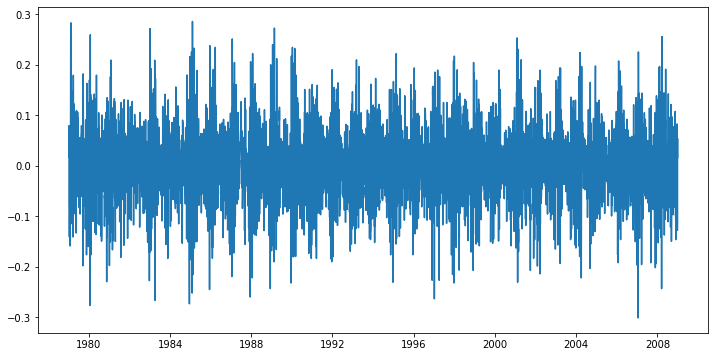

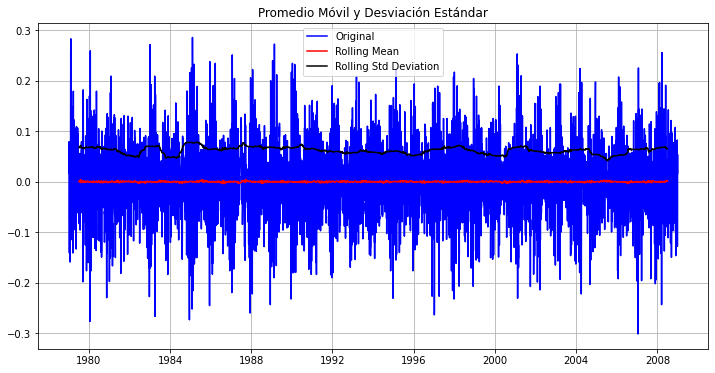

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.562068e+01
p-value                        1.733499e-28
#Lags Used                     3.800000e+01
Number of Observations Used    1.088200e+04
Critical Value (1%)           -3.430951e+00
Critical Value (5%)           -2.861806e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


In [9]:
#Comenzaremos por intentar eliminar la estacionaridad de los datos usando la funcion .shift() de pandas:

#Entendiendo la funcion de .shift()
#plt.plot(ts_TMaxTest_log10_EWM_diff, color='orange')
#plt.show()

#test=ts_TMaxTest_log10_EWM_diff.shift(periods=365)
#plt.plot(test,color='orange')
#plt.show()

ts_TMaxTest_log10_shft=ts_TMaxTest_log10.shift(periods=7)

#Haciendo la diferencia entre el df normal y el df con shift de 7 dias
ts_TMaxTest_log10_shftdiff=ts_TMaxTest_log10-ts_TMaxTest_log10_shft
#print(ts_TMaxTest_log10_shftdiff.head(10))
plt.plot(ts_TMaxTest_log10_shftdiff)#.loc['1979-01-08':'2008-12-31'])
plt.show()

ts_TMaxTest_log10_shftdiff.dropna(inplace=True)#Para eliminar los primeros 7 valores nulos
test_stationarity(ts_TMaxTest_log10_shftdiff)


$\text{Podemos observar que el promedio movible se ha vuelto casi lineal, mientras que la desviacion estandar movible es mucho mas estable que en la ultima grafica}$

$\text{Ahora intentaremos hacer lo mismo pero usando la descomposicion que se uso en la actividad pasada:}$

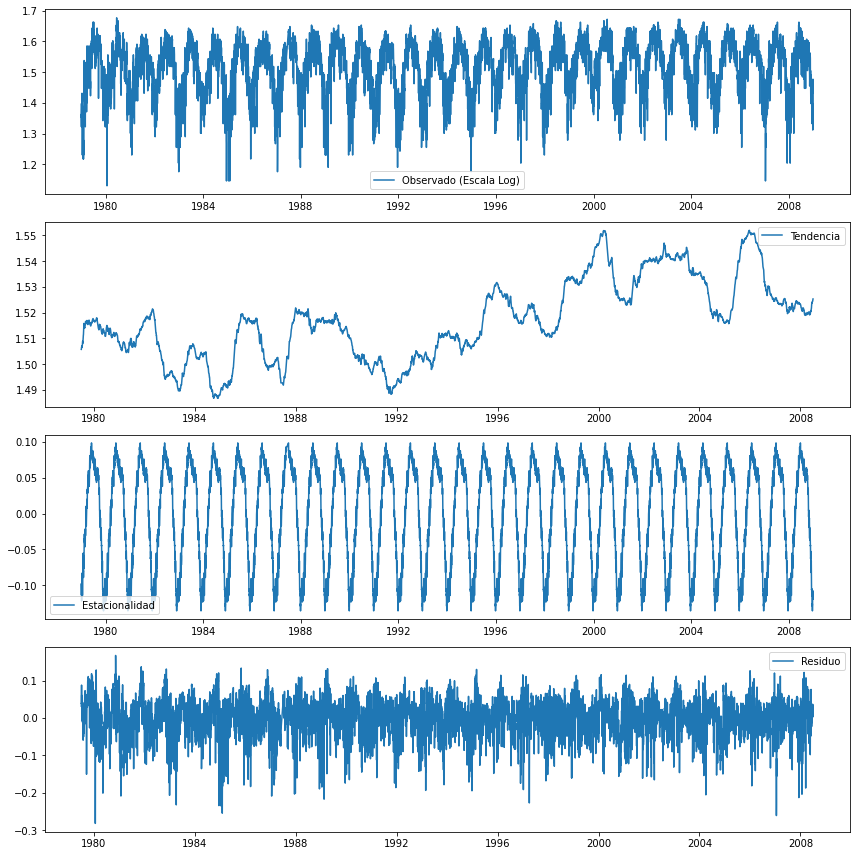


---------------------------


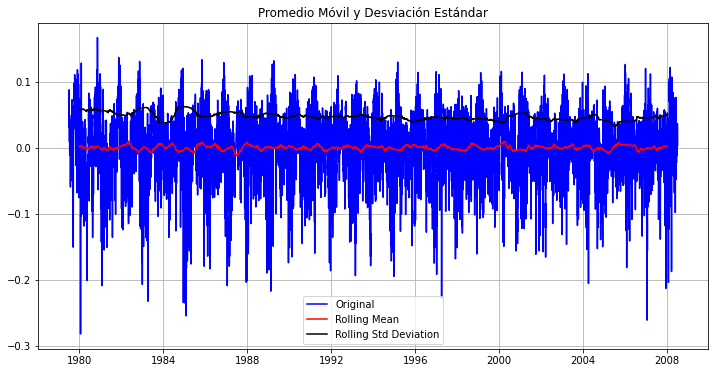

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.333467e+01
p-value                        6.085771e-25
#Lags Used                     2.800000e+01
Number of Observations Used    1.053500e+04
Critical Value (1%)           -3.430971e+00
Critical Value (5%)           -2.861814e+00
Critical Value (10%)          -2.566916e+00
dtype: float64


In [10]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decompositionTMaxlog = sm.tsa.seasonal_decompose(ts_TMaxTest_log10.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decompositionTMaxlog.trend
seasonal = decompositionTMaxlog.seasonal
residue = decompositionTMaxlog.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_TMaxTest_log10, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();
plt.show()
print('\n---------------------------')

#Ahora vamos a hacer un test de la grafica de residuo, eliminando Tendencia y Estacinoalidad:
ts_TMaxTest_logresid=residue
ts_TMaxTest_logresid.dropna(inplace=True)
test_stationarity(ts_TMaxTest_logresid)


$\text{Como podemos ver, esta ultima grafica es menos estable que la que se genero con el metodo de .shift(). Sin embargo, esta ultima sigue siendo estacionaria.}$

# $\underline{\text{PARTE 2: PRONOSTICO DE SERIES DE TIEMPO}}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


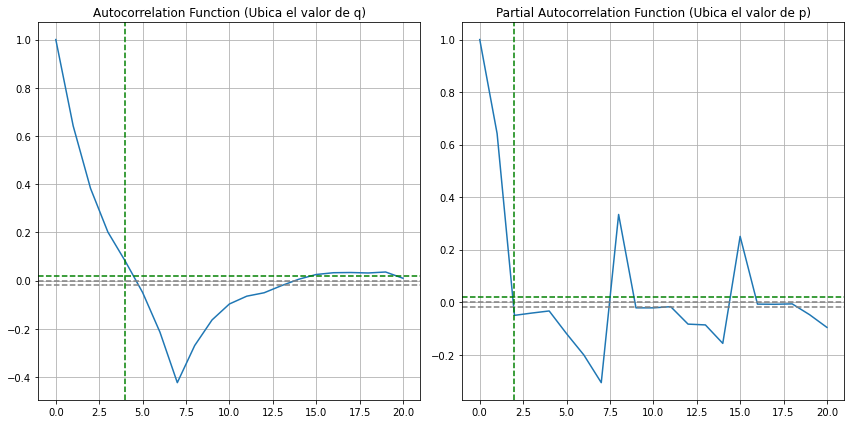

In [11]:
#Ahora comenzaremos a aplicar el modelo ARIMA
lag_acf = acf(ts_TMaxTest_log10_shftdiff, nlags=20)
lag_pacf = pacf(ts_TMaxTest_log10_shftdiff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TMaxTest_log10_shftdiff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TMaxTest_log10_shftdiff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TMaxTest_log10_shftdiff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TMaxTest_log10_shftdiff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

$\text{Podemos ver que la linea superior coincide con la grafica alrededor de 2.5, por lo que se hara p=2.5}$

$\text{Tambien vemos que la linea inferior coincide basicamente en el mismo punto, por lo que q=2.5}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                10927
Model:                 ARIMA(2, 1, 0)   Log Likelihood               20761.032
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sun, 21 Feb 2021   AIC                         -41514.064
Time:                        23:32:26   BIC                         -41484.868
Sample:                             1   HQIC                        -41504.225
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.128e-06      0.000      0.031      0.975      -0.001       0.001
ar.L1.D.TMax    -0.1667      0.009    -17.623      0.000      -0.185      -0.148
ar.L2.D.TMax    -0.1493      0.009    -15.78

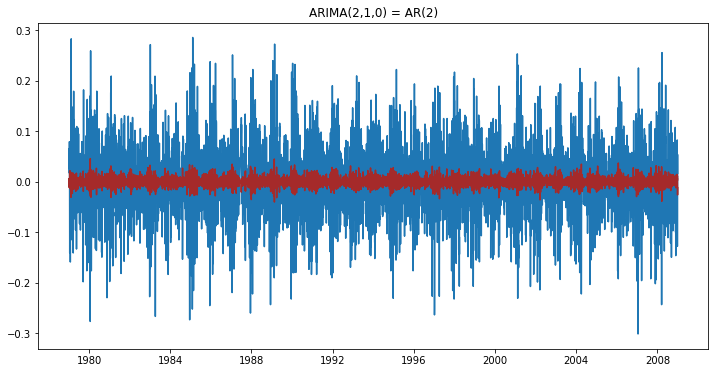

In [15]:
#MODELO DE AUTO REGRESION:

# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_TMaxTest_log10, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_TMaxTest_log10_shftdiff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                10927
Model:                 ARIMA(0, 1, 2)   Log Likelihood               20955.525
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sun, 21 Feb 2021   AIC                         -41903.050
Time:                        23:51:05   BIC                         -41873.854
Sample:                             1   HQIC                        -41893.211
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.934e-06      0.000      0.043      0.966      -0.000       0.000
ma.L1.D.TMax    -0.2747      0.010    -28.228      0.000      -0.294      -0.256
ma.L2.D.TMax    -0.2510      0.011    -23.59

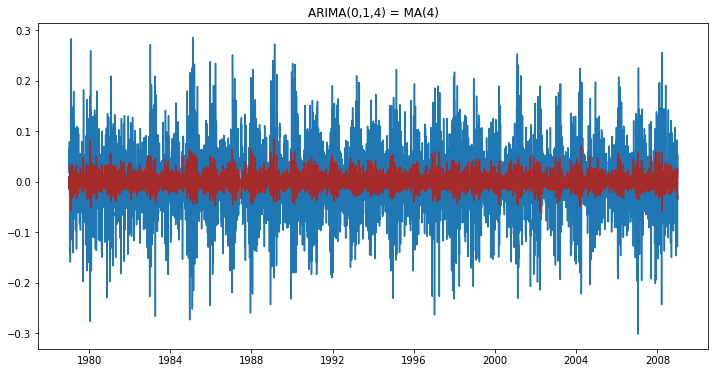

In [21]:
#MODELO MOVING AVERAGE (PROMEDIO MOVIBLE):

# Modelo MA(q): (p,d,q) = (0,1,2) 
model = ARIMA(ts_TMaxTest_log10, order=(0,1,2), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_TMaxTest_log10_shftdiff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                10927
Model:                 ARIMA(2, 1, 2)   Log Likelihood               21177.934
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sun, 21 Feb 2021   AIC                         -42343.868
Time:                        23:51:02   BIC                         -42300.074
Sample:                             1   HQIC                        -42329.109
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.598e-06   9.25e-05      0.061      0.952      -0.000       0.000
ar.L1.D.TMax     0.9249      0.174      5.324      0.000       0.584       1.265
ar.L2.D.TMax    -0.2296      0.106     -2.16

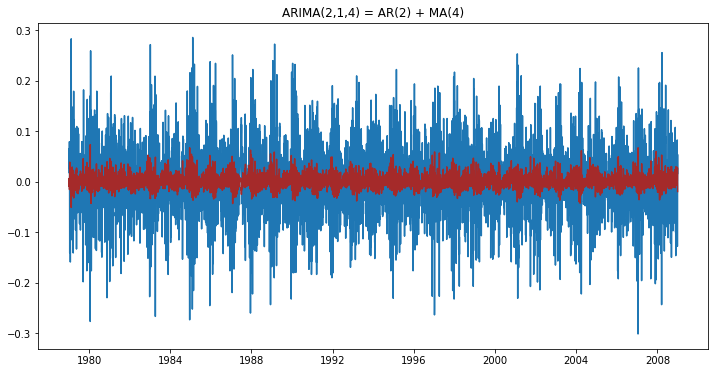

In [20]:
#MODELO ARIMA (MA + AR):

# Modelo ARIMA(p): (p,d,q) = (2,1,2) 
model = ARIMA(ts_TMaxTest_log10, order=(2,1,2), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_TMaxTest_log10_shftdiff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
#AIC's de los modelos:



#-41514.064
#-41903.050
#-42343.868 Este es el mejor modelo (ARIMA MA + AR)


$\text{Ahora vamos a regresar a la escala original, con el modelo de ARIMA (2,1,2)}$

FECHA
1979-01-02    0.000006
1979-01-03    0.004235
1979-01-04    0.006257
1979-01-05   -0.008368
1979-01-06   -0.000602
                ...   
2008-12-27    0.006934
2008-12-28    0.027567
2008-12-29    0.006139
2008-12-30   -0.017195
2008-12-31   -0.019310
Length: 10927, dtype: float64
FECHA
1979-01-01         NaN
1979-01-02    1.332444
1979-01-03    1.326454
1979-01-04    1.404197
1979-01-05    1.343814
dtype: float64
FECHA
2008-12-27    1.318688
2008-12-28    1.425507
2008-12-29    1.483260
2008-12-30    1.459926
2008-12-31    1.412054
dtype: float64


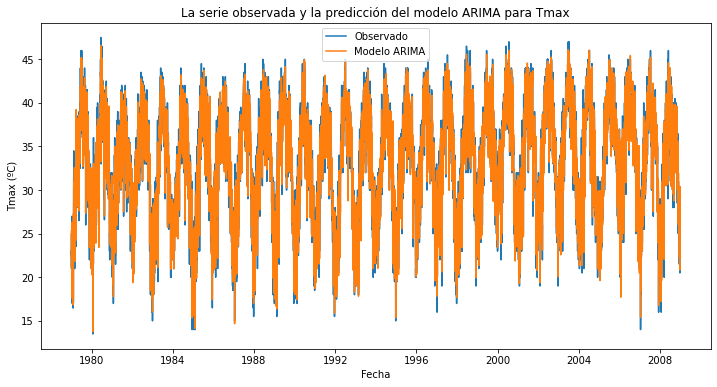

In [25]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)


# Le sumamos las predicciones de ARIMA a la serie observada (ts_TMaxTest_log10)
predictions_ARIMA_log = pd.Series(ts_TMaxTest_log10, index = ts_TMaxTest_log10.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_TMaxTest, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

RMSE: 0.8732867509884734


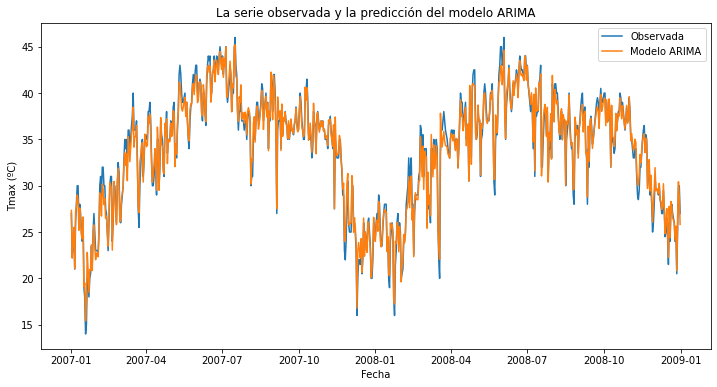

In [28]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_TMaxTest)**2))
print('RMSE:', RMSE)

# Graficamos sólo los útimos datos de las series 
ts_TMaxtest_inferiores = ts_TMaxTest.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_TMaxtest_inferiores, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

